In [2]:
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, StableDiffusionPipeline, DDIMScheduler

import sys
sys.path.append("..") 

from tiny_nerf.utils.ray_utils import get_ray_directions, get_rays
from camera_view_generator.camera import generate_random_poses
from tiny_nerf.nerf import NerfModel, render_rays
import torch.nn.functional as F

from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm


import numpy as np

torch_device = 'cpu'

In [3]:
model_key = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_key, torch_dtype=torch.float32)

#pipe.enable_sequential_cpu_offload()
#pipe.enable_vae_slicing()
#pipe.unet.to(memory_format=torch.channels_last)
#pipe.enable_attention_slicing(1)
#pipe.enable_model_cpu_offload()

pipe.to(torch_device)

vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet

scheduler = DDIMScheduler.from_pretrained(model_key, subfolder="scheduler", torch_dtype=torch.float32)

t_range=[0.02, 0.98]

num_train_timesteps = scheduler.config.num_train_timesteps
min_step = int(num_train_timesteps * t_range[0])
max_step = int(num_train_timesteps * t_range[1])



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Just to see Stable Diffusion image generation

/tmp/ipykernel_19925/1665513311.py:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

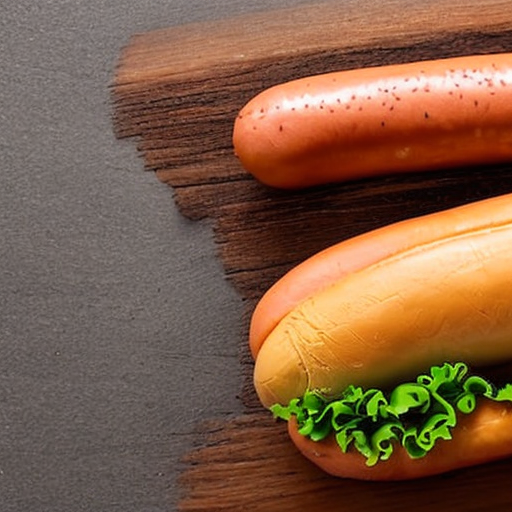

In [4]:
# Some settings

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

prompt = ["A hotdog on the white background"]
height = 512                        # default height of Stable Diffusion
width = 512                       # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        #sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [4]:
def view_image(image, H, W):
    # expected image of the format H*W, 3
    image = image.reshape(H, W, 3)
    print(image.shape)
    pil_image = Image.fromarray((image*255).detach().numpy().astype(np.uint8))
    pil_image.show()

Generate all possible extenstions of the text prompts and save its embeddings

In [5]:
# Prep text
prompt = 'Delicious hotdog'


# extensions as proposed in paper
directions = ['front', 'side', 'back', 'bottom', 'overhead']

embed_dict = {}

for direction in directions:
    extended_prompt = f'{prompt} {direction} view'
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embed_dict[direction] = text_encoder(text_input.input_ids.to(torch_device))[0]


max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""], padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    embed_dict['unconditional'] = text_encoder(uncond_input.input_ids.to(torch_device))[0]


Helper function to generate rays

In [6]:
def generate_all_rays(size, H, W, focal):
    # get rays for each pixel for a random camera position
    poses, dirs = generate_random_poses(size)
    directions = get_ray_directions(H, W, focal)
    all_rays = []

    for pose in poses:
        origin, direction = get_rays(directions, pose)
        all_rays += [torch.cat([origin, direction], 1)]
    all_rays = torch.cat(all_rays, 0)

    return all_rays, dirs

In [7]:
def map_directions_to_text_embeddings(directions, embeddings):
    cond_embeddings = [embeddings[str(dir)] for dir in directions]
    cond_embeddings = torch.cat(cond_embeddings, 0)
    uncond_embeddings = [embeddings['unconditional'] for _ in range(len(directions))]
    uncond_embeddings = torch.cat(uncond_embeddings, 0)
    return torch.cat([cond_embeddings, uncond_embeddings], 0)

Implement one step of the training loop using Score Distillation Sampling as Loss function for NERF

In [8]:
# some parameters
default_fov = 20
guidance_scale = 100
H = 64
W = 64
BATCH_SIZE = 20
focal = H / (2 * np.tan(np.deg2rad(default_fov) / 2))

# get rays for each pixel for a random camera position
all_rays, dirs = generate_all_rays(BATCH_SIZE, H, W, focal)

# render view from this coordinates
nerf_model = NerfModel(hidden_dim=128).to(torch_device)
generated_view = render_rays(nerf_model, ray_origins=all_rays[:,:3], ray_directions=all_rays[:, 3:6])
#view_image(generated_view, H, W)
#print(generated_view.shape)

# create latent representation of the image (would probably need to interpolate received image)
generated_view = generated_view.reshape(BATCH_SIZE, H, W, 3).permute(0, 3, 1, 2)
#print(generated_view.shape)
generated_view_i512 = F.interpolate(generated_view, (512, 512), mode='bilinear', align_corners=False)
#print(generated_view_i512.shape)
#view_image(generated_view_i512, H, W)


 # encode image into latents with vae, requires grad!
posterior = vae.encode(generated_view_i512).latent_dist
latents = posterior.sample() * vae.config.scaling_factor
print(latents.shape)
#view_image(latents, H, W)

# map directions to the text prompt

# timestep ~ U(0.02, 0.98) to avoid very high/low noise level
t = torch.randint(min_step, max_step + 1, (latents.shape[0],), dtype=torch.long, device=torch_device)

# predict the noise residual with unet, NO grad!
with torch.no_grad():
    # create noise
    noise = torch.randn_like(latents)
    # add noise to the latent representation
    latents_noisy = scheduler.add_noise(latents, noise, t)
    # twice as much latents in order to run both guided generation and unconditional generation 
    latent_model_input = torch.cat([latents_noisy] * 2)
    tt = torch.cat([t] * 2)
    # map directions to the text prompt
    text_embeddings = map_directions_to_text_embeddings(dirs, embed_dict)
    noise_pred = unet(latent_model_input, tt, encoder_hidden_states=text_embeddings).sample

    # perform guidance, guidance in paper was around 100
    noise_pred_uncond, noise_pred_pos = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_pos - noise_pred_uncond)

# calculate SDS
grad_scale = 1

alphas = scheduler.alphas_cumprod.to(torch_device)
w = (1 - alphas[t])

grad = grad_scale * w[:, None, None, None] * (noise_pred - noise)
grad = torch.nan_to_num(grad)

targets = (latents - grad).detach()
loss = 0.5 * F.mse_loss(latents.float(), targets, reduction='sum') / latents.shape[0]

# feedback SDS to update Nerf Parameters
loss